In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
from models import RMLPRegressor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/immunomodulation/log_normalized/regression/'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    data.train.embeddings, 
    data.train.fingerprints
), axis=1)
validation_X = torch.concat((
    data.validation.embeddings, 
    data.validation.fingerprints
), axis=1)
test_X = torch.concat((
    data.test.embeddings, 
    data.test.fingerprints
), axis=1)

In [4]:
train_Y = torch.concat((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)
validation_Y = torch.concat((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)
test_Y = torch.concat((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)

## MLP Model

## Train

  6%|██▋                                       | 32/512 [00:45<11:22,  1.42s/it]


Val.: 0.0954
Test: 0.0836


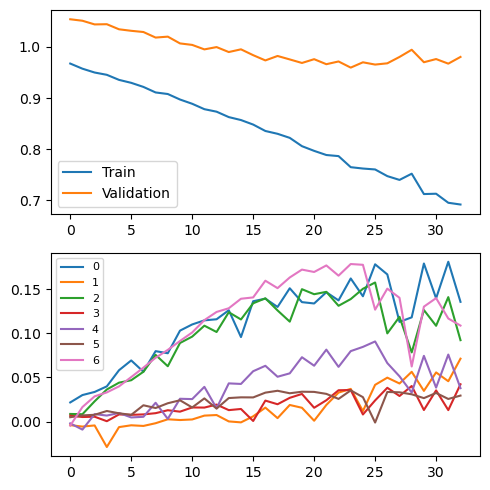

In [5]:
mlp = RMLPRegressor(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=256, dropout=0.5
).to(device)

validation_score = mlp.fit(
    train_X, train_Y, 
    validation_X, validation_Y, 
    lr=0.0001, epochs=512, batch_size=32, 
    early_stopping=True, plot=True
)
test_score = mlp.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')

## Visualization

In [6]:
test_predictions = mlp(test_X).detach()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i].cpu(), test_predictions[:, i].cpu(), s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()